# Code required for Google Colab

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if not IN_COLAB:
    print("No Colab")

No Colab


In [3]:
# # create the data directory
# !mkdir visual_wake_words

# # download and unzip dataset
# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/test_person.zip 
# !unzip test_person.zip -d ./visual_wake_words/test
# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/test_non_person.zip 
# !unzip test_non_person.zip -d ./visual_wake_words/test

# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/train_non_person.zip 
# !unzip train_non_person.zip -d ./visual_wake_words/train
# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/train_person.zip 
# !unzip train_person.zip -d ./visual_wake_words/train

# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/val_non_person.zip 
# !unzip val_non_person.zip -d ./visual_wake_words/val
# !wget https://tiny-cnn.s3.eu-central-1.amazonaws.com/val_person.zip 
# !unzip val_person.zip -d ./visual_wake_words/val


In [4]:
# from google.colab import drive
# drive.mount("/content/drive")

# %cd "./drive/MyDrive/tiny_cnn"

In [5]:
# !pip install mltk
# !pip install wandb

# Experiment Workbench

In [6]:
import os, sys, math, datetime, configparser
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image
import seaborn as sns
import socket
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score



import tensorflow as tf
#import tensorflow_datasets as tfds
#from tensorflow import keras
keras = tf.keras
from keras.layers import ReLU
from keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate, Reshape, Multiply, Add, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
 # Import the necessary MLTK APIs
#from mltk.core import view_model,  profile_model # summarize_model

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths
#from workbench.utils.utils import parse_model_name
#from workbench.data.data import get_vvw_dataset, get_lemon_quality_dataset
from workbench.tensorflow import set_batchnorm_momentum, set_dropout
from workbench.wandb import wandb_model_DB, get_model_DB_run_id_from_architecture


#from dotenv import load_dotenv
import wandb
#from wandb import AlertLevel
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

%load_ext autoreload

In [7]:
# try:
#     model_names = []
#     with open("deployment_list.txt", "r") as file:
#         lines = file.readlines()
#         for line in lines:
#             if len(line) < 2:
#                 pass
#             else:
#                 model_names.append(line.strip())

#     print(model_names)
# except:
#     pass

In [8]:
HOST_NAME = socket.gethostname()
HOST_NAME

if HOST_NAME in ["default"]:
    config = configparser.ConfigParser()
    config.read("config.ini")

    HOST_NAME = config['MACHINE']['HOST_NAME']

In [9]:
%reload_ext autoreload
%autoreload

In [10]:
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

# Confirm that TensorFlow can access GPU
device_name = tf.test.gpu_device_name()
if not device_name:
  #raise SystemError('GPU device not found')
  print('GPU device not found')

else:
  print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.0
Found GPU at: /device:GPU:0


# Model architecture

In [11]:
global model_name
model_name = "mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.MV1LRE"


In [12]:
# tf.compat.v1.disable_eager_execution()

# DANGER ZONE: Disable warning messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [13]:
tf.keras.backend.clear_session()

https://www.tensorflow.org/api_docs/python/tf/random/set_seed  

Operations that rely on a random seed actually derive it from two seeds: the global and operation-level seeds. This sets the global seed.

Its interactions with operation-level seeds is as follows:

1. If neither the global seed nor the operation seed is set: A randomly picked seed is used for this op.  
2. If the global seed is set, but the operation seed is not: The system deterministically picks an operation seed in conjunction with the global seed so that it gets a unique random sequence. Within the same version of tensorflow and user code, this sequence is deterministic. However across different versions, this sequence might change. If the code depends on particular seeds to work, specify both global and operation-level seeds explicitly.  
3. If the operation seed is set, but the global seed is not set: A default global seed and the specified operation seed are used to determine the random sequence.  
4. If both the global and the operation seed are set: Both seeds are used in conjunction to determine the random sequence.

In [14]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_2

# set the random seeds
#os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism() 

# Node: 'gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/UnsortedSegmentSum'
#Deterministic GPU implementation of unsorted segment reduction op not available.
#	 [[{{node gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/UnsortedSegmentSum}}]] [Op:__inference_train_function_10280]

In [15]:
models_dir = initialize()

# Visual Wake Words dataset


In [16]:
if IN_COLAB:
    #path to the base directory of the visual_wake_words dataset
    vww_path = Path("/content/visual_wake_words")

else:
    vww_path = Path.cwd().joinpath("datasets","visual_wake_words")
vww_path.exists()

True

# Get the model

In [17]:
models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path = create_filepaths(model_name)

c:\tiny_mlc\tiny_cnn\models


In [19]:
model_tf_path_trained =  models_dir.joinpath(model_name, f"{model_name}_trained.h5")
models_tf_path_pb = models_path.joinpath(f"{model_name}", "saved_model")

In [20]:
model = keras.models.load_model(models_tf_path)

In [21]:
global base_model_name
global alpha
global resolution
global channels
global classes
global variation
global early_stopping_patience

In [22]:
base_model_name, alpha, resolution, channels, classes, variation = model_name.split("_")

# Set training parameters

In [23]:
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Experiment Workbench'
#dataset = "lemon_quality"
#dataset = "lemon_binary_datagen"
#dataset = "vvw_minval"
#dataset = "vvw_minval_datagen
#dataset = "vvw_minval_fix"
dataset = "vvw_minval_datagen_fix"
IMG_HEIGHT = resolution
IMG_WIDTH = resolution
BATCH_SIZE = 50
EPOCHS = 50
#LOGGING_STEPS = 64
MOMENTUM = 0.9
LR = 0.001
DROPOUT = 0.2
early_stopping_patience = 30

# BatchNormalization parameters
BATCH_NORM_MOMENTUM = 0.9    # Standard 0.9 # TensorFlow default = 0<000
BATCH_NORM_EPSILON = 0.001

#PROJECT = base_model_name
PROJECT = "model_DB_visual_wake_words"
ENTITY = "susbrock"
WANDB_ONLINE = True

shuffle_seed = seed

In [24]:
alpha = float(alpha)
resolution = int(resolution)
classes = int(classes.strip("o"))
channels = int(channels.strip("c"))

## Setting the BatchNorm Momentum

In [25]:
model = set_batchnorm_momentum(model, BATCH_NORM_MOMENTUM)
variation = variation + ".BN" + str(BATCH_NORM_MOMENTUM)

In [26]:
model = set_dropout(model, DROPOUT)


In [27]:
# # for layer in model.layers:
#     if layer is isinstance(tf.keras.layers.Dropout(rate =DROPOUT)):
#         print(layer.rate)'


In [28]:
# Start a Tensorboard session
%load_ext tensorboard

# Prepare the Lemon Quality Dataset

In [29]:
lemon_dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
lemon_dataset_path.exists()

True

In [30]:

#lemon_binary_datagen 

def get_lemon_binary_datagen(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    lemon_binary_dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset_binary")
    TRAIN_DIR = lemon_binary_dataset_path.joinpath("train")
    VAL_DIR = lemon_binary_dataset_path.joinpath("val")
    TEST_DIR = lemon_binary_dataset_path.joinpath("test")
    #BASE_DIR_TEST = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96_test")
    #Path.exists(BASE_DIR)
    validation_split = 0
    color_mode = "rgb"

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=.1,
        horizontal_flip=True,
        #validation_split=validation_split,
        rescale=1. / 255)
    
    train_generator = datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        subset='training',
        color_mode=color_mode,
        class_mode="sparse")
    
    val_generator = datagen.flow_from_directory(
        VAL_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        subset='validation',
        color_mode=color_mode,
        class_mode="sparse")
    
    test_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
    
    test_generator = test_gen.flow_from_directory(
        TEST_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE, # was 1
        #subset = "validation",
        color_mode=color_mode,
        class_mode="sparse")
    
    #print (f"Class names: {class_names}")
    #print(f"Train: {train_generator.element_spec}")
    #print(f"Normalize: {normalize}")

    class_names  = ["bad_quality", "good_quality"]
    return (train_generator, val_generator, test_generator, class_names)


# Visual Wake Words minval


In [31]:
def get_vvw_minval_dataset(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    
    BASE_DIR = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96")
    BASE_DIR_TEST = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96_test")
    Path.exists(BASE_DIR)
    validation_split = 0.1
    color_mode = "rgb"


    print("Preparing vvw_minval_training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        BASE_DIR,
        validation_split=validation_split,
        subset="training",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=batch_size,
        color_mode=color_mode,
        shuffle=True
        )

    class_names = train_ds.class_names

    print("Preparing vvw_minval_validation dataset...")        
    val_ds = tf.keras.utils.image_dataset_from_directory(
        BASE_DIR,
        validation_split=validation_split,
        subset="validation",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=batch_size,
        color_mode=color_mode,
        shuffle=True
        )

    print("Preparing test dataset...")        
    test_ds = tf.keras.utils.image_dataset_from_directory(
        BASE_DIR_TEST,
        validation_split=None,
        #subset="validation",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=1,
        color_mode=color_mode,
        shuffle=False
        )


    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential([
            tf.keras.layers.RandomRotation(10), #0.1
            tf.keras.layers.RandomTranslation(
                height_factor = 0.05,
                width_factor = 0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomFlip("horizontal")
        ]
        )

    train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )
    val_ds= val_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    # Normalize the data to the range [0, 1]
    normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

    train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y)) #, num_parallel_calls=tf.data.AUTOTUNE)
    labels = class_names
    
    print (f"Class names: {class_names}")
    print(f"Train: {train_ds.element_spec}")
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [32]:
def get_vvw_minval_dataset_fix(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    
    TRAIN_DIR = Path.cwd().joinpath("datasets", "visual_wake_words", "train")
    VAL_DIR = Path.cwd().joinpath("datasets", "visual_wake_words", "val")
    TEST_DIR = Path.cwd().joinpath("datasets", "visual_wake_words", "test")
    #Path.exists(BASE_DIR)
    #validation_split = 0.1
    color_mode = "rgb"


    print("Preparing vvw_minval_training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        #validation_split=validation_split,
        #subset="training",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=batch_size,
        color_mode=color_mode,
        shuffle=True
        )

    class_names = train_ds.class_names

    print("Preparing vvw_minval_validation dataset...")        
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR,
        #validation_split=validation_split,
        #subset="validation",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=batch_size,
        color_mode=color_mode,
        shuffle=True
        )

    print("Preparing test dataset...")        
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        #validation_split=None,
        #subset="validation",
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        #labels=labels,
        batch_size=1,
        color_mode=color_mode,
        shuffle=False
        )


    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential([
            tf.keras.layers.RandomRotation(10), #0.1
            tf.keras.layers.RandomTranslation(
                height_factor = 0.05,
                width_factor = 0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomFlip("horizontal")
        ]
        )

    train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )
    val_ds= val_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    # Normalize the data to the range [0, 1]
    normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

    train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y)) #, num_parallel_calls=tf.data.AUTOTUNE)
    labels = class_names
    
    print (f"Class names: {class_names}")
    print(f"Train: {train_ds.element_spec}")
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [33]:
# BASE_DIR = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96")
# BASE_DIR_TEST = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96_test")
# Path.exists(BASE_DIR)
# validation_split = 0.1
# color_mode = "rgb"

In [34]:
# print("Preparing training dataset...")        
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     BASE_DIR,
#     validation_split=validation_split,
#     subset="training",
#     seed=shuffle_seed,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #labels=labels,
#     batch_size=BATCH_SIZE,
#     color_mode=color_mode,
#     shuffle=True
#     )

# class_names = train_ds.class_names

# print("Preparing validation dataset...")        
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     BASE_DIR,
#     validation_split=validation_split,
#     subset="validation",
#     seed=shuffle_seed,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #labels=labels,
#     batch_size=BATCH_SIZE,
#     color_mode=color_mode,
#     shuffle=True
#     )

# print("Preparing test dataset...")        
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     BASE_DIR_TEST,
#     validation_split=None,
#     #subset="validation",
#     seed=shuffle_seed,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     #labels=labels,
#     batch_size=1,
#     color_mode=color_mode,
#     shuffle=False
#     )


#     #   Preprocessing form Visual Wake Word Challenge:
#     #   rotation_range=10,
#     #   width_shift_range=0.05,
#     #   height_shift_range=0.05,
#     #   zoom_range=.1,
#     #   horizontal_flip=True,
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#         tf.keras.layers.RandomRotation(0.1), #0,1
#         tf.keras.layers.RandomTranslation(
#             height_factor = 0.05,
#             width_factor = 0.05
#         ),
#         tf.keras.layers.RandomZoom(0.1),
#         tf.keras.layers.RandomFlip("horizontal")
#     ]
#     )

# train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )


# # Normalize the data to the range [0, 1]

# normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

# train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y)) #, num_parallel_calls=tf.data.AUTOTUNE)
# labels = class_names


In [35]:
def get_vvw_minval_datagen(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    BASE_DIR = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96")
    BASE_DIR_TEST = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96_test")
    Path.exists(BASE_DIR)
    validation_split = 0.1
    color_mode = "rgb"

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=.1,
        horizontal_flip=True,
        validation_split=validation_split,
        rescale=1. / 255)
    
    train_generator = datagen.flow_from_directory(
        BASE_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        subset='training',
        color_mode=color_mode,
        class_mode="sparse")
    
    # val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #     rotation_range=10,
    #     width_shift_range=0.05,
    #     height_shift_range=0.05,
    #     zoom_range=.1,
    #     horizontal_flip=True,
    #     validation_split=validation_split,
    #     rescale=1. / 255)

    val_generator = datagen.flow_from_directory(
        BASE_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        subset='validation',
        color_mode=color_mode,
        class_mode="sparse")
    
    test_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
    
    test_generator = test_gen.flow_from_directory(
        BASE_DIR_TEST,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE, # was 1
        color_mode=color_mode,
        subset='validation',
        class_mode="sparse")
    
    #print (f"Class names: {class_names}")
    #print(f"Train: {train_generator.element_spec}")
    #print(f"Normalize: {normalize}")

    class_names  = ["non_person", "person"]
    return (train_generator, val_generator, test_generator, class_names)

In [36]:
def get_vvw_minval_datagen_fix(dataset_path, img_width, img_height, batch_size, channels, normalize=True):
    TRAIN_DIR = dataset_path.joinpath("train")
    VAL_DIR = dataset_path.joinpath("val")
    TEST_DIR = dataset_path.joinpath("test")
    #Path.exists(BASE_DIR)
    #validation_split = 0
    color_mode = "rgb"

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=.1,
        horizontal_flip=True,
        #validation_split=validation_split,
        rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        #subset='training',
        color_mode=color_mode,
        class_mode="sparse",
        shuffle=True
        )
    

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        #subset='validation',
        color_mode=color_mode,
        class_mode="sparse",
        shuffle=True)
    
    test_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
    
    test_generator = test_gen.flow_from_directory(
        TEST_DIR,
        target_size=(img_height, img_width),
        batch_size=1,# BATCH_SIZE, # was 1
        color_mode=color_mode,
        #subset='validation',
        class_mode="sparse",
        shuffle=False)
    
    #print (f"Class names: {class_names}")
    #print(f"Train: {train_generator.element_spec}")
    #print(f"Normalize: {normalize}")

    class_names  = ["non_person", "person"]
    return (train_generator, val_generator, test_generator, class_names)

In [37]:
# BASE_DIR = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96")
# BASE_DIR_TEST = Path.cwd().parent.joinpath("tiny_mlperf", "vw_coco2014_96_test")
# Path.exists(BASE_DIR)
# validation_split = 0.1
# color_mode = "rgb"

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=10,
#       width_shift_range=0.05,
#       height_shift_range=0.05,
#       zoom_range=.1,
#       horizontal_flip=True,
#       validation_split=validation_split,
#       rescale=1. / 255)
# train_generator = datagen.flow_from_directory(
#     BASE_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     subset='training',
#     color_mode='rgb',
#     class_mode="sparse")
# val_generator = datagen.flow_from_directory(
#     BASE_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     subset='validation',
#     color_mode='rgb',
#     class_mode="sparse")


# print(train_generator.class_indices)

In [38]:
# def train_epochs(model, train_generator, val_generator, epoch_count,
#                  learning_rate):
#   model.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate),
#       #loss='categorical_crossentropy',
#       loss='sparse_categorical_crossentropy',
#       metrics=['accuracy'])
#   history_fine = model.fit(
#       train_generator,
#       steps_per_epoch=len(train_generator),
#       epochs=epoch_count,
#       validation_data=val_generator,
#       validation_steps=len(val_generator),
#       batch_size=BATCH_SIZE)
#   return model

In [39]:
# model = train_epochs(model, train_generator, val_generator, 20, 0.001)
# model = train_epochs(model, train_generator, val_generator, 10, 0.0005)
# model = train_epochs(model, train_generator, val_generator, 20, 0.00025)
# model.save(filepath="vvw_model.h5")

In [40]:
#input_shape = (IMG_WIDTH, IMG_HEIGHT, channels)
#train_ds, val_ds, test_ds, labels = get_vvw_dataset(input_shape, BATCH_SIZE)

In [41]:
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     img = tf.keras.preprocessing.image.array_to_img(
#                 images[0], scale=True
#             )
#     display(img)

In [42]:
# class_names = labels
# print(class_names)

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")'

In [43]:
# from PIL import Image
# img = np.random.random(size=(100, 100, 3))
# pil_img = tf.keras.utils.array_to_img(img)

In [44]:
# for image_batch, labels_batch in train_ds:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     print(labels_batch)
#     break

In [45]:
# classes = len(labels)
# print(f"The dataset contains {classes } classes.")

# Choose dataset

In [46]:
def get_dataset(name, classes):
    if name == "lemon_quality":
        train_ds, val_ds, test_ds, class_names = get_lemon_quality_dataset(lemon_dataset_path, resolution, resolution, BATCH_SIZE, channels)
        dataset_name = "lemon_quality"

    elif name == "lemon_binary_datagen":
        train_ds, val_ds, test_ds, class_names = get_lemon_binary_datagen(None, resolution, resolution, BATCH_SIZE, channels, normalize=True)
        dataset_name = "lemon_binary_datagen"
    elif name == "vvw_minval":
        train_ds, val_ds, test_ds, class_names = get_vvw_minval_dataset(None, resolution, resolution, BATCH_SIZE, channels, normalize=True)
        dataset_name = "vvw_minval"
    elif name == "vvw_minval_fix":
        train_ds, val_ds, test_ds, class_names = get_vvw_minval_dataset_fix(None, resolution, resolution, BATCH_SIZE, channels, normalize=True)
        dataset_name = "vvw_minval_fix"


    elif name == "vvw_minval_datagen":
        train_ds, val_ds, test_ds, class_names = get_vvw_minval_datagen(None, resolution, resolution, BATCH_SIZE, channels, normalize=True)
        dataset_name = "vvw_minval_datagen"  
    elif name == "vvw_minval_datagen_fix":
        train_ds, val_ds, test_ds, class_names = get_vvw_minval_datagen_fix(vww_path, resolution, resolution, BATCH_SIZE, channels, normalize=True)
        dataset_name = "vvw_minval_datagen_fix"  
    else:
        print(f"Dataset {name} is not a valid dataset")
        train_ds, val_ds, test_ds, class_names, dataset_name = 0


    if len(class_names) != classes:
        print(f"Incompatible dataset and model. \n, \
            Model uses {classes} classes - dataset has {len(class_names)} classes!")
    else:
        pass
    
    return train_ds, val_ds, test_ds, class_names, dataset_name



In [47]:
train_ds, val_ds, test_ds, class_names, dataset_name = get_dataset(dataset, classes)

Found 87695 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.
Found 10963 images belonging to 2 classes.


In [48]:
#test_ds.samples

# Define the model

In [49]:
logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
root_logdir = os.getcwd()

In [50]:
if dataset_name not in  ["vvw_minval_datagen", "vvw_minval_datagen_fix", "lemon_binary_datagen"]:

    tf.keras.backend.clear_session()

    # optimize the data flow
    AUTOTUNE = tf.data.AUTOTUNE
    #train_ds = train_ds.cache().prefetch(AUTOTUNE)
    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [51]:
api = wandb.Api(timeout=19)

In [52]:
# code taken from https://www.tensorflow.org/guide/keras/custom_callback#examples_of_keras_callback_applications

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [53]:
class EarlyStoppingAtMaxValAccuracy(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after max has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=30):
        super(EarlyStoppingAtMaxValAccuracy, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = 0
        self.best_epoch = 0
        self.best_epoch_loss = np.Infinity

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_accuracy")
        if np.greater(current, self.best):
            self.best = current
            self.best_epoch = epoch
            self.best_epoch_loss = logs.get("val_loss")
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

        metrics = dict()
        metrics["best_epoch"] = self.best_epoch
        metrics["best_val_accuracy"] = self.best
        metrics["best_epoch_loss"] = self.best_epoch_loss

        wandb.log(metrics)



    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        



# Train the model


In [54]:
if WANDB_ONLINE == True:
    os.environ["WANDB_MODE"] = "online"
else:
    os.environ["WANDB_MODE"] = "offline"
    

def train_model_wandb(model, train_ds, val_ds, test_ds):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        if len(wandb.patched["tensorboard"]) > 0:
                wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # Generate run ids
        id = wandb.sdk.lib.runid.generate_id()

        run = wandb.init(
                # Set the project where this run will be logged
                project=PROJECT,
                name = model_name,
                id = id, 
                #resume=True,
                #resume="must",
                sync_tensorboard=True
                )

        # if wandb.run.resumed:
        #        model = keras.models.load_model(wandb.restore("model-best.h5").name)

        global BATCH_SIZE
        # Specify the configuration variables
        config = wandb.config
        
        config.batch_size = BATCH_SIZE
        #config.dropout =DROPOUT
        config.learn_rate = LR
        config.momentum = MOMENTUM
        #config.decay = 1e-6
        config.epochs = EPOCHS
        config.classes = classes
        config.id = id
        config.seed = seed
        config.architecture = model_name
        config.dataset = dataset_name
        config.batch_norm_momentum = BATCH_NORM_MOMENTUM
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        METRICS = ['accuracy',
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        #keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]

        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

       # optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM)
        config.optimizer = optimizer._name

        model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy
                        metrics=['accuracy'])
                        #metrics=METRICS)

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=0, update_freq="epoch") #, profile_batch="10, 20")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        def lr_schedule(epoch):
                """
                Returns a custom learning rate that decreases as epochs progress.
                """
                learning_rate = LR
                if epoch > 20:
                        learning_rate = 0.0001
                tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
                return learning_rate

        def lr_vvw(epoch, lr):
                """
                Returns the learing rate schedule used in training for Visual Wake Word dataset.
                """
        
                if epoch <= 20: # was 20
                        lr = 0.001
                elif epoch <= 30:
                        lr = 0.0005
                else:
                        lr = 0.00025
                return lr


        lr_callback = LearningRateScheduler(lr_vvw)
        #lr_callback = LearningRateScheduler(lr_schedule)

        #best_model_path = Path(wandb.run.dir).joinpath(f"best_model")

        checkpoint = WandbModelCheckpoint("best_model",
                monitor="val_accuracy",
                save_best_only=True,
                save_freq="epoch")

        global early_stopping_patience
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=early_stopping_patience) # TODO: should this be the loss?

        callbacks =[
                #tensorboard_callback,
                lr_callback,
                #wandb_callback,
                WandbMetricsLogger(),
                checkpoint,
                #early_stopping,
                #EarlyStoppingAtMaxValAccuracy()
        ]

        print(f"Training on {dataset_name}")
        print(wandb.run.dir)

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        #wandb.save("last_model.h5")

        print("finished training")

        model.save(model_tf_path_trained)

        #best_model = keras.models.load_model(best_model_path) # not needed due to "restore_best_weights=True"

        # y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
        # y_val_pred = model.predict(val_ds).argmax(axis=1)

        print("Predict on test dataset")



        # for x_test, y_test in test_ds:
        # #test_ds = list(test_ds)

        # print("Get predictions on test set")
        # y_test_pred = model.predict(test_ds).argmax(axis=1)
        # print("Get y_test_true:")
        # y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

        # print("finish predictions")

        print("evaluate on test dataset")
        results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
        print("test loss, test acc:", results)
        wandb.log({
                "test_loss" : results[0],
                "test_accuracy" : results[1]
        })

        # # log data for the confusion matrix
        # wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
        #                 y_true=y_test_true, preds=y_test_pred, #y_test_true[0]
        #                 class_names=class_names)})


        wandb.config.update({"hostname": HOST_NAME})

        wandb.alert(
        title="Training finished", 
        text=f"Training of model: {model_name} on host {HOST_NAME} has finished.",
        level=wandb.AlertLevel.INFO,
        #wait_duration=300
        )
        
        run.finish()
        return history, model, run.id

In [55]:
%env "WANDB_NOTEBOOK_NAME" "Experiment Workbench.ipynb"

env: "WANDB_NOTEBOOK_NAME"="Experiment Workbench.ipynb"


In [56]:
wandb.finish()
history, model, run_id = train_model_wandb(model, train_ds, val_ds, test_ds)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Training on vvw_minval_datagen_fix
c:\tiny_mlc\tiny_cnn\wandb\run-20230507_202100-i1wqir4i\files
1754/1754 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.6777INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets
wandb: Adding directory to artifact (.\best_model)... Done. 0.0s


1754/1754 [==============================] - 411s 218ms/step - loss: 0.5950 - accuracy: 0.6777 - val_loss: 0.5347 - val_accuracy: 0.7337 - lr: 0.0010
finished training
Predict on test dataset
evaluate on test dataset
10963/10963 [==============================] - 97s 9ms/step - loss: 0.5324 - accuracy: 0.7368
test loss, test acc: [0.5323503017425537, 0.7368420958518982]


epoch/accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/lr,▁
epoch/val_accuracy,▁
epoch/val_loss,▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.6777
epoch/epoch,0


In [57]:
model.save(model_tf_path_trained)
model.save(models_tf_path_pb)

INFO:tensorflow:Assets written to: c:\tiny_mlc\tiny_cnn\models\mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.MV1LRE\mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.MV1LRE\saved_model\assets


INFO:tensorflow:Assets written to: c:\tiny_mlc\tiny_cnn\models\mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.MV1LRE\mobilenettiny_0.7_96_c3_o2_l5ll16pl64b0.25.MV1LRE\saved_model\assets


# Restore the model from wandb

In [53]:
#run_id = "fqubvbej"

In [54]:
# run = wandb.init()
# artifact = run.use_artifact(f"{ENTITY}/{PROJECT}/run_{run_id}_model:latest", type='model')
# artifact_dir = artifact.download(root="temp")
# # extract model filename
# #model_filename = os.listdir(artifact_dir)[0]
# model = tf.keras.models.load_model("temp")
# model.name
# run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


wandb:   4 of 4 files downloaded.  


# Conversion to TFLite

In [58]:
models_tflite_trained_path = models_dir.joinpath(model_name, f"{model_name}_trained.tflite")
models_tflite_opt_trained_path = models_dir.joinpath(model_name, f"{model_name}INT8_trained.tflite")

In [59]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter = tf.lite.TFLiteConverter.from_saved_model(models_path)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpscrgs9s7\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpscrgs9s7\assets


In [60]:

# Save the model.
with open(models_tflite_trained_path, "wb") as f:
    f.write(tflite_model)

# Conversion to TFLite with INT8 quantization

In [61]:
train_ds, val_ds, test_ds, class_names, dataset_name = get_dataset(dataset, classes)

Found 87695 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.
Found 10963 images belonging to 2 classes.


In [ ]:
# def convert_tflite_quant_INT8(model, data_generator):
#     converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)

#     # set the optimization flag
#     converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
#     # enforce integer only quantization
#     converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     converter_opt.inference_input_type = tf.int8
#     converter_opt.inference_output_type = tf.int8

#     # provide a representative dataset for quantization
#     converter_opt.representative_dataset = data_generator

#     tflite_model_opt = converter_opt.convert()

#     return tflite_model_opt

In [62]:
def representative_data_gen():
    for i in range(20):
    #   for sample, _ in dataset.validation_dataset():
        test_image, y_true = next(test_ds)
        yield [np.expand_dims(test_image[0], axis=0)]
        #yield [test_image[0]]

converter_opt = tf.lite.TFLiteConverter.from_keras_model(model)

# set the optimization flag
converter_opt.optimizations = [tf.lite.Optimize.DEFAULT]
# enforce integer only quantization
converter_opt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


# https://github.com/tensorflow/tensorflow/issues/53293: uint is no longer supported!
#converter_opt.inference_input_type = tf.uint8
#converter_opt.inference_output_type = tf.uint8
converter_opt.inference_input_type = tf.int8
converter_opt.inference_output_type = tf.int8

# provide a representative dataset for quantization
converter_opt.representative_dataset = representative_data_gen

tflite_model_opt = converter_opt.convert()

# Save the model.
with open(models_tflite_opt_trained_path , 'wb') as f:
  f.write(tflite_model_opt)


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpvpzgbfbz\assets


INFO:tensorflow:Assets written to: C:\Users\Susanne\AppData\Local\Temp\tmpvpzgbfbz\assets
d:\Miniconda\envs\tiny_cnn_6\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Run the TensorFlow Lite models


In [61]:
# train_ds, val_ds, test_ds, class_names, dataset_name = get_dataset(dataset, classes)

Found 87695 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.
Found 10963 images belonging to 2 classes.


In [68]:
# #@tf.function
# def tflite_predict(model_path, test_image):
#     # Initialize the interpreter
#     interpreter = tf.lite.Interpreter(model_path=str(model_path))
#     interpreter.allocate_tensors()

#     input_details = interpreter.get_input_details()[0]
#     output_details = interpreter.get_output_details()[0]

#     print(input_details['dtype'])

#     # Check if the input type is quantized, then rescale input data to uint8
#     if input_details['dtype'] == np.int8:  # was np.uint8
#         input_scale, input_zero_point = input_details["quantization"]
#         #print(f"input_scale {input_scale}")
#         #print(f"input_zero_point {input_zero_point}")
#         test_image = test_image / input_scale + input_zero_point
#         #print(test_image)


#     test_image = test_image.astype(input_details["dtype"])
#     #
#     interpreter.set_tensor(input_details["index"], test_image)
#     #interpreter.set_tensor(input_details["index"], np.expand_dims(test_image[0], axis=0)) # only needed when input shape (96, 96, 3)
#     interpreter.invoke()
#     output = interpreter.get_tensor(output_details["index"])[0]
#     #dequantized_output = (output - input_zero_point) * input_scale
#     prediction =output.argmax()
#     print(f"Prediction: Class {prediction} derived from {output}")

#     return prediction

In [69]:
# test_image, test_label = next(test_ds)
# test_label

array([0.], dtype=float32)

In [70]:
# tflite_result = tflite_predict(models_tflite_trained_path , test_image)
# tflite_result

<class 'numpy.float32'>
Prediction: Class 0 derived from [0.7307286 0.2692714]


0

In [101]:
# tflite_result = tflite_predict(models_tflite_opt_trained_path , test_image)
# tflite_result

In [ ]:

# def tflite_predict_on_dataset(model_path, dataset):
#     # find length of dataset
#     test_gen = dataset.as_numpy_iterator()
#     num_images = len(list(test_gen))

#     predictions = []
#     y_trues = []

#     test_gen = dataset.as_numpy_iterator()
#     accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
#     # iterate over the complete test_set
#     for i in range(num_images):
#         test_image, y_true = next(test_gen)
#         prediction = tflite_predict(model_path, test_image)
#         predictions.append(prediction)
#         y_trues.append(y_true[0])
#         #accuracy.update_state(y_true, prediction) # TODO: correct accuracy
#         print(f"{i}, {test_image.shape} - true label: {y_true[0]} vs {tflite_result}")

#     #accuracy = (np.sum(predictions == y_trues) * 100) / num_images
#     print(f"Accuracy: {accuracy.result()} - (Number of test samples: {num_images})")
#     return predictions, y_trues    

In [71]:
# #@tf.function
# def tflite_predict_on_datagen(model_path, dataset):
#     # find length of dataset
#     test_gen = dataset#.as_numpy_iterator()
#     num_images = test_gen.samples

#     predictions = []
#     y_trues = []

#     accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
#     # iterate over the complete test_set
#     for i in range(num_images):
#         test_image, y_true = next(test_gen)
#         prediction = tflite_predict(model_path, test_image)
#         #print(prediction)
#         predictions.append(prediction)
#         y_trues.append(y_true[0])
#         #accuracy.update_state(y_true, prediction) # TODO: correct accuracy
#         print(f"{i}, {test_image.shape} - true label: {y_true[0]} vs {prediction}")

#     #accuracy = (np.sum(predictions == y_trues) * 100) / num_images
#     print(f"Accuracy: {accuracy.result()} - (Number of test samples: {num_images})")
#     return predictions, y_trues    

In [72]:
# predictions_tflite, y_trues_tflite = tflite_predict_on_datagen(models_tflite_trained_path, test_ds)

<class 'numpy.float32'>
Prediction: Class 0 derived from [0.8596712  0.14032881]
0, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.92152643 0.07847359]
1, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.5725754 0.4274246]
2, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 1 derived from [0.2625755 0.7374245]
3, (1, 96, 96, 3) - true label: 0.0 vs 1
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.6629561  0.33704382]
4, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.9223438  0.07765617]
5, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.5136202 0.4863799]
6, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Prediction: Class 0 derived from [0.8193146  0.18068543]
7, (1, 96, 96, 3) - true label: 0.0 vs 0
<class 'numpy.float32'>
Predic

Found 87695 images belonging to 2 classes.
Found 10961 images belonging to 2 classes.
Found 10963 images belonging to 2 classes.


In [102]:
#train_ds, val_ds, test_ds, class_names, dataset_name = get_dataset(dataset, classes)
#predictions_INT8, y_trues_INT8 = tflite_predict_on_datagen(models_tflite_opt_trained_path , test_ds)

In [103]:
# # Compare prediction results with ground truth labels to calculate accuracy.
# accurate_count = 0
# for index in range(len(predictions)):
# if predictions[index] == y_trues[index]:
#     accurate_count += 1
# accuracy = accurate_count * 1.0 / len(predictions)


# predictions_INT8, y_trues_INT8

In [78]:
# accuracy = (np.sum(preds == trues) * 100) / num_test_images
# accuracy

# Model evaluation

In [81]:
# test_predictions = model.predict(test_ds)
# test_predictions

In [ ]:
#predictions_tflite, y_trues_tflite

In [87]:
# AUC = roc_auc_score(y_true=y_trues_tflite, y_score=predictions_tflite)
# print(f"AUC score:{AUC}")
# F1 = f1_score(y_true=y_trues_tflite, y_pred=predictions_tflite)
# print(f"F1 score:{F1}")

AUC score:0.7034355419969349
F1 score:0.6404861032969505


In [88]:
# confusion_mtx_tflite = tf.math.confusion_matrix(y_trues_tflite, predictions_tflite, num_classes=classes)
# confusion_mtx_tflite

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[4922,  727],
       [2468, 2846]])>

In [89]:
# def show_confusion_matrix(cm, labels):
#   plt.figure(figsize=(6, 6))
#   sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
#               annot=True, fmt='g')
#   plt.xlabel('Prediction')
#   plt.ylabel('Label')
#   plt.show()
#   return plt

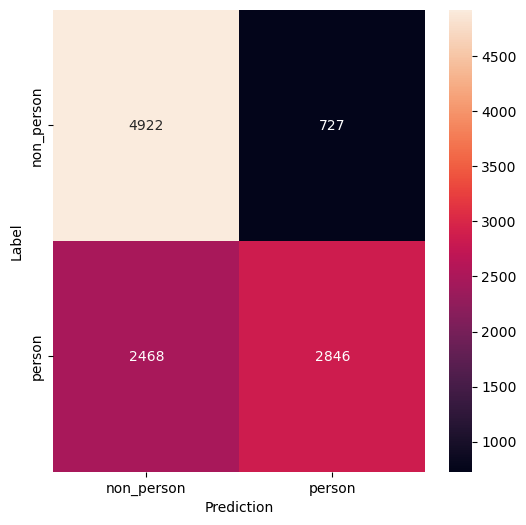

In [90]:
# my_plot = show_confusion_matrix(confusion_mtx_tflite, class_names)

In [100]:
# import plotly.graph_objects as go

# fig = go.Figure(data=go.Heatmap(
#                    z=confusion_mtx_tflite,
#                    x=class_names,
#                    y=class_names,
#                    hoverongaps = False),
#                    )
# fig.update_traces(text=confusion_mtx_tflite, texttemplate="%{text}", hovertemplate=None)
# fig.update_layout(title=go.layout.Title(text='tflite confusion matrix'),
#                             xaxis_title='prediction',
#                             yaxis_title='label'
#                             )

# fig.show()

## Code reserved for troubleshooting